In [1]:
"""
@author: pho
"""
%load_ext autoreload
%autoreload 2
import sys
import importlib
from pathlib import Path
from datetime import datetime

import numpy as np
import pandas as pd

# required to enable non-blocking interaction:
%gui qt
# %gui qt5
# from PyQt5.Qt import QApplication
# # start qt event loop
# _instance = QApplication.instance()
# if not _instance:
#     _instance = QApplication([])
# app = _instance
import pyqtgraph as pg
from pyqtgraph.Qt import QtCore, QtGui

# ## Panel:
# import param
# import panel as pn
# from panel.interact import interact, interactive, fixed, interact_manual
# from panel.viewable import Viewer

# pn.extension()

## Pho's Custom Libraries:
from pyphocorehelpers.general_helpers import get_arguments_as_optional_dict, inspect_callable_arguments
from pyphocorehelpers.function_helpers import compose_functions
from pyphocorehelpers.indexing_helpers import partition, build_spanning_bins, compute_spanning_bins, compute_position_grid_size, compute_paginated_grid_config
from pyphocorehelpers.print_helpers import PrettyPrintable, WrappingMessagePrinter
from pyphocorehelpers.geometry_helpers import compute_data_extent, compute_data_aspect_ratio, corner_points_from_extents
from pyphocorehelpers.DataStructure.dynamic_parameters import DynamicParameters
from pyphocorehelpers.gui.interaction_helpers import CallbackWrapper

# pyPhoPlaceCellAnalysis:
from pyphoplacecellanalysis.General.Pipeline.NeuropyPipeline import NeuropyPipeline # get_neuron_identities
from pyphoplacecellanalysis.General.SessionSelectionAndFiltering import batch_filter_session
from pyphoplacecellanalysis.General.ComputationResults import ComputationResult
from pyphoplacecellanalysis.General.KnownDataSessionTypeProperties import KnownDataSessionTypeProperties
from pyphoplacecellanalysis.General.Pipeline.Stages.Display import DefaultDisplayFunctions
from pyphoplacecellanalysis.General.Pipeline.Stages.DisplayFunctions.Ratemaps import DefaultRatemapDisplayFunctions
from pyphoplacecellanalysis.General.Pipeline.Stages.DisplayFunctions.DecoderPredictionError import DefaultDecoderDisplayFunctions

# NeuroPy (Diba Lab Python Repo) Loading
try:
    from neuropy import core

    importlib.reload(core)
except ImportError:
    sys.path.append(r"C:\Users\Pho\repos\NeuroPy")  # Windows
    # sys.path.append('/home/pho/repo/BapunAnalysis2021/NeuroPy') # Linux
    # sys.path.append(r'/Users/pho/repo/Python Projects/NeuroPy') # MacOS
    print("neuropy module not found, adding directory to sys.path. \n >> Updated sys.path.")
    from neuropy import core

# Neuropy:
from neuropy.core.session.data_session_loader import DataSessionLoader
from neuropy.core.session.dataSession import DataSession
from neuropy.analyses.placefields import PlacefieldComputationParameters, perform_compute_placefields
from neuropy.analyses.laps import estimation_session_laps
from neuropy.core.epoch import NamedTimerange

from neuropy.analyses.placefields import PlacefieldComputationParameters, perform_compute_placefields
from neuropy.core.neuron_identities import NeuronIdentity, build_units_colormap, PlotStringBrevityModeEnum
from neuropy.utils.debug_helpers import debug_print_placefield, debug_print_spike_counts, debug_print_subsession_neuron_differences
from neuropy.plotting.ratemaps import enumTuningMap2DPlotVariables

known_data_session_type_dict = {'kdiba':KnownDataSessionTypeProperties(load_function=(lambda a_base_dir: DataSessionLoader.kdiba_old_format_session(a_base_dir)),
                               basedir=Path(r'R:\data\KDIBA\gor01\one\2006-6-07_11-26-53')),
                'bapun':KnownDataSessionTypeProperties(load_function=(lambda a_base_dir: DataSessionLoader.bapun_data_session(a_base_dir)),
                               basedir=Path('R:\data\Bapun\Day5TwoNovel'))
               }
known_data_session_type_dict['kdiba'].post_load_functions = [lambda a_loaded_sess: estimation_session_laps(a_loaded_sess)]


# known_data_session_type_dict['kdiba'].name
from matplotlib.figure import Figure
import matplotlib.pyplot as plt
%matplotlib qt
from matplotlib.transforms import IdentityTransform

neuropy module not found, adding directory to sys.path. 
 >> Updated sys.path.


# Common Setup

In [2]:
enable_saving_to_disk = False
# common_parent_foldername = Path(r'R:\Dropbox (Personal)\Active\Kamran Diba Lib\Pho-Kamran-Meetings\Final Placemaps 2021-01-14')
common_parent_foldername = Path(r'R:\Dropbox (Personal)\Active\Kamran Diba Lib\Pho-Kamran-Meetings\2022-01-16')

def compute_position_grid_bin_size(x, y, num_bins=(64,64), debug_print=False):
    """ Compute Required Bin size given a desired number of bins in each dimension
    Usage:
        active_grid_bin = compute_position_grid_bin_size(curr_kdiba_pipeline.sess.position.x, curr_kdiba_pipeline.sess.position.y, num_bins=(64, 64)
    """
    out_grid_bin_size, out_bins, out_bins_infos = compute_position_grid_size(x, y, num_bins=num_bins)
    active_grid_bin = tuple(out_grid_bin_size)
    if debug_print:
        print(f'active_grid_bin: {active_grid_bin}') # (3.776841861770752, 1.043326930905373)
    return active_grid_bin

# WARNING! TODO: Changing the smooth values from (1.5, 1.5) to (0.5, 0.5) was the difference between successful running and a syntax error!
# try:
#     active_grid_bin
# except NameError as e:
#     print('setting active_grid_bin = None')
#     active_grid_bin = None
# finally:
#     # active_session_computation_config = PlacefieldComputationParameters(speed_thresh=10.0, grid_bin=active_grid_bin, smooth=(1.0, 1.0), frate_thresh=0.2, time_bin_size=0.5) # if active_grid_bin is missing, figure out the name
#     active_session_computation_config = PlacefieldComputationParameters(speed_thresh=10.0, grid_bin=active_grid_bin, smooth=(1.0, 1.0), frate_thresh=0.2, time_bin_size=0.5) # if active_grid_bin is missing, figure out the name

## Dynamic mode:
def _build_active_computation_configs(sess):
    """ _get_computation_configs(curr_kdiba_pipeline.sess) 

        # From Diba:
        # (3.777, 1.043) # for (64, 64) bins
        # (1.874, 0.518) # for (128, 128) bins

    """
    # active_grid_bin = compute_position_grid_bin_size(sess.position.x, sess.position.y, num_bins=(64, 64))
    # active_session_computation_config.computation_epochs = None # set the placefield computation epochs to None, using all epochs.
    # return [PlacefieldComputationParameters(speed_thresh=10.0, grid_bin=compute_position_grid_bin_size(sess.position.x, sess.position.y, num_bins=(64, 64)), smooth=(1.0, 1.0), frate_thresh=0.2, time_bin_size=0.5, computation_epochs = None)]
    # return [PlacefieldComputationParameters(speed_thresh=10.0, grid_bin=compute_position_grid_bin_size(sess.position.x, sess.position.y, num_bins=(128, 128)), smooth=(2.0, 2.0), frate_thresh=0.2, time_bin_size=0.5, computation_epochs = None)]
    return [PlacefieldComputationParameters(speed_thresh=10.0, grid_bin=compute_position_grid_bin_size(sess.position.x, sess.position.y, num_bins=(64, 64)), smooth=(2.0, 2.0), frate_thresh=0.2, time_bin_size=1.0, computation_epochs = None)]
    # return [PlacefieldComputationParameters(speed_thresh=10.0, grid_bin=(3.777, 1.043), smooth=(1.0, 1.0), frate_thresh=0.2, time_bin_size=0.5, computation_epochs = None)]

    # return [PlacefieldComputationParameters(speed_thresh=10.0, grid_bin=compute_position_grid_bin_size(sess.position.x, sess.position.y, num_bins=(32, 32)), smooth=(1.0, 1.0), frate_thresh=0.2, time_bin_size=0.5, computation_epochs = None),
    #         PlacefieldComputationParameters(speed_thresh=10.0, grid_bin=compute_position_grid_bin_size(sess.position.x, sess.position.y, num_bins=(64, 64)), smooth=(1.0, 1.0), frate_thresh=0.2, time_bin_size=0.5, computation_epochs = None),
    #         PlacefieldComputationParameters(speed_thresh=10.0, grid_bin=compute_position_grid_bin_size(sess.position.x, sess.position.y, num_bins=(128, 128)), smooth=(1.0, 1.0), frate_thresh=0.2, time_bin_size=0.5, computation_epochs = None),
    #        ]



In [3]:


# The output should be created in common_parent_foldername
def _display_custom_user_function(computation_result, active_config, **kwargs):
    """ custom display function testing """
    def _set_figure_save_root_day_computed_mode(plotting_config, active_session_name, active_epoch_name, debug_print=False):
        """ Outputs to a path with the style of  """
        out_figure_save_original_root = plotting_config.get_figure_save_path('test') # 2022-01-16/
        if debug_print:
            print(f'out_figure_save_original_root: {out_figure_save_original_root}')
        # Update output figure root:
        out_day_date_folder_name = datetime.today().strftime('%Y-%m-%d') # 2022-01-16
        new_out_day_day_parent_dir = Path('output', out_day_date_folder_name, active_session_name, active_epoch_name)
        out_figure_save_root = plotting_config.change_active_out_parent_dir(new_out_day_day_parent_dir)
        # out_figure_save_root = active_config.plotting_config.get_figure_save_path(out_day_date_folder_name, active_session_name, active_epoch_names.name) # 2022-01-16/
        if debug_print:
            print(f'out_figure_save_root: {out_figure_save_root}') # out_figure_save_root: output\2006-6-07_11-26-53\maze1\2022-01-18\2006-6-07_11-26-53\maze1
        return plotting_config
    
    
    print(f'_display_custom_user_function(computation_result, active_config, **kwargs):')
    # print(f'active_config.keys(): {list(active_config.keys())}') # active_config.keys(): ['active_session_config', 'active_epochs', 'video_output_config', 'plotting_config', 'computation_config', 'filter_config']
    # print(f'active_config.plotting_config: {active_config.plotting_config}')
    # print(f'active_config.active_session_config: {active_config.active_session_config}')
    active_session_name = active_config.active_session_config.session_name
    print(f'active_session_name: {active_session_name}')
    active_epoch_names = active_config.active_epochs
    print(f'active_epoch_names.name: {active_epoch_names.name}') # active_epoch_names: <NamedTimerange: {'name': 'maze1', 'start_end_times': array([  22.26      , 1739.15336412])};>
    # active_epoch_names.name: maze1
    active_config.plotting_config = _set_figure_save_root_day_computed_mode(active_config.plotting_config, active_session_name, active_epoch_names.name)
    # get the output path for this figure name:
    out_figure_save_root = active_config.plotting_config.get_figure_save_path('test_plot')
    print(f'out_figure_save_root: {out_figure_save_root}')
    
    # Now convert the computation parameters for filename display:
    print(f'active_config.computation_config: {active_config.computation_config}')
    curr_computation_config_output_dir_name = active_config.computation_config.str_for_filename(False)
    print(f'curr_computation_config_output_dir_name: {curr_computation_config_output_dir_name}')
    out_figure_save_current_computation_dir = active_config.plotting_config.get_figure_save_path(curr_computation_config_output_dir_name)
    print(f'out_figure_save_current_computation_dir: {out_figure_save_current_computation_dir}')
    
    return out_figure_save_root, out_figure_save_current_computation_dir
    

<!-- https://matplotlib.org/stable/_images/sphx_glr_polys3d_001.png -->

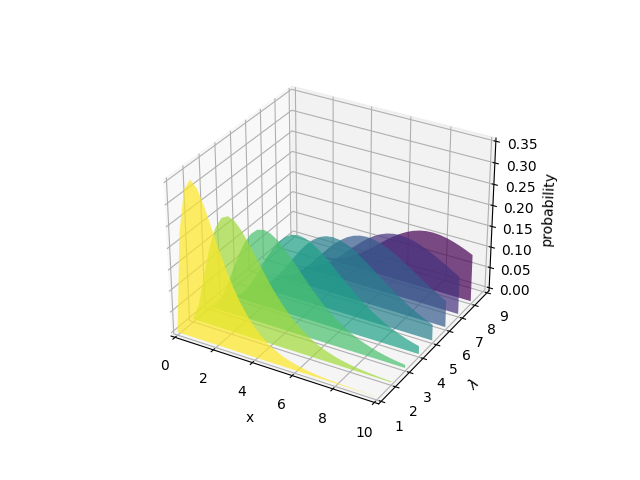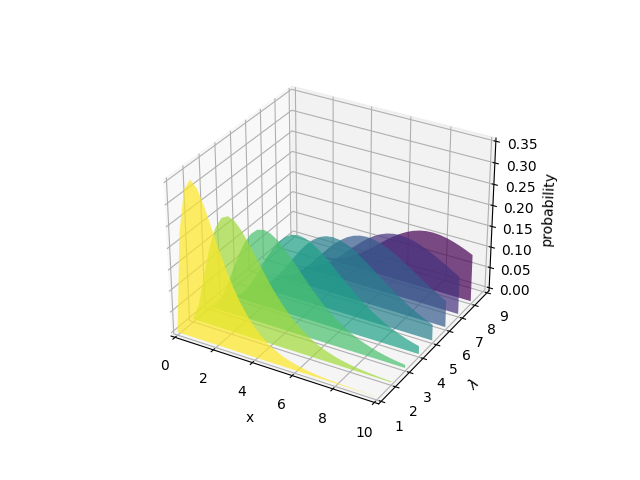
See https://matplotlib.org/stable/gallery/mplot3d/polys3d.html

See https://matplotlib.org/stable/gallery/mplot3d/bars3d.html
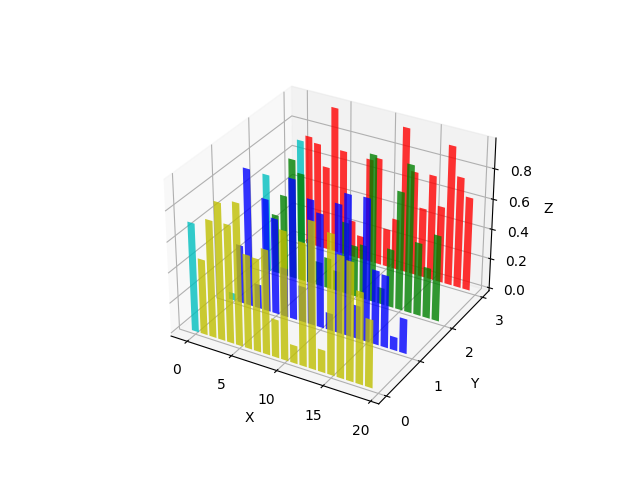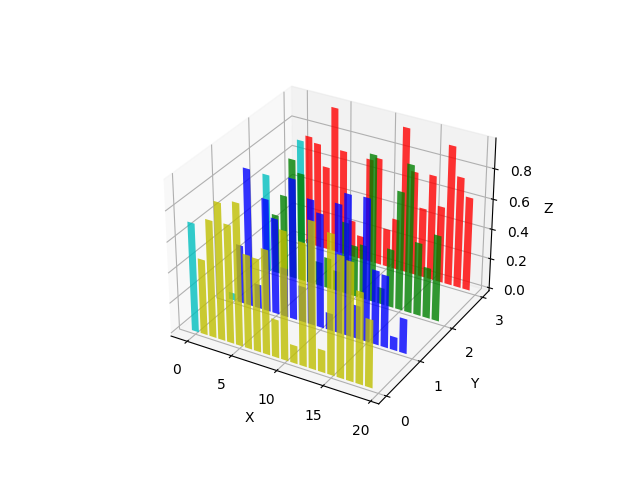


In [ ]:
# from scipy.stats import multivariate_normal

# multivariate_normal.pdf()


# from sklearn.neighbors import KernelDensity

# kde = KernelDensity(kernel='gaussian', bandwidth=1.0).fix(X)

# Bapun Format:

In [3]:
# curr_bapun_pipeline = NeuropyPipeline(name='bapun_pipeline', session_data_type='bapun', basedir=known_data_session_type_dict['bapun'].basedir, load_function=known_data_session_type_dict['bapun'].load_function)
curr_bapun_pipeline = NeuropyPipeline.init_from_known_data_session_type('bapun', known_data_session_type_dict['bapun'])
active_session_computation_configs = _build_active_computation_configs(curr_bapun_pipeline.sess)
# active_session_computation_config.grid_bin = compute_position_grid_bin_size(curr_bapun_pipeline.sess.position.x, curr_bapun_pipeline.sess.position.y, num_bins=(64, 64))

basedir is already Path object.
	 basepath: R:\data\Bapun\Day5TwoNovel
	 session_name: RatS-Day5TwoNovel-2020-12-04_07-55-09
converting neuron_type strings to core.neurons.NeuronType objects...
	 done.
Issue with pickled POSIX_PATH on windows for path R:\data\Bapun\Day5TwoNovel\RatS-Day5TwoNovel-2020-12-04_07-55-09.probegroup.npy, falling back to non-pickled version...
Position falling back to legacy loading protocol...: dict_rep: {'traces': array([[-50.946354, -50.946354, -50.946354, ..., -45.350155, -45.350155,
        -45.350155],
       [-50.646282, -50.646282, -50.646282, ...,  64.150757,  64.150757,
         64.150757],
       [  7.124897,   7.124897,   7.124897, ...,   5.571329,   5.571329,
          5.571329]]), 'computed_traces': array([[nan, nan, nan, ..., nan, nan, nan]]), 't_start': 0, 'sampling_rate': 60, 'metadata': None}
linearized position loaded from file.
Loading success: .flattened.spikes.npy.
Loading success: .ripple.npy.
Loading success: .mua.npy.
Loading success: 

In [4]:
# Bapun/DataFrame style session filter functions:
def build_bapun_any_maze_epochs_filters(sess):
    def _temp_filter_session_by_epoch1(sess):
        """ 
        Usage:
            active_session, active_epoch = _temp_filter_session(curr_bapun_pipeline.sess)
        """
        active_epoch = sess.epochs.get_named_timerange('maze1')
        ## All Spikes:
        # active_epoch_session = sess.filtered_by_epoch(active_epoch) # old
        active_session = batch_filter_session(sess, sess.position, sess.spikes_df, active_epoch.to_Epoch())
        return active_session, active_epoch

    def _temp_filter_session_by_epoch2(sess):
        """ 
        Usage:
            active_session, active_epoch = _temp_filter_session(curr_bapun_pipeline.sess)
        """
        active_epoch = sess.epochs.get_named_timerange('maze2')
        ## All Spikes:
        # active_epoch_session = sess.filtered_by_epoch(active_epoch) # old
        active_session = batch_filter_session(sess, sess.position, sess.spikes_df, active_epoch.to_Epoch())
        return active_session, active_epoch

    # return {'maze1':_temp_filter_session_by_epoch1}
    return {'maze1':_temp_filter_session_by_epoch1,
            'maze2':_temp_filter_session_by_epoch2
           }

    # return {'maze1': lambda x: (x.filtered_by_epoch(x.epochs.get_named_timerange('maze1')), x.epochs.get_named_timerange('maze1')),
    #         'maze2': lambda x: (x.filtered_by_epoch(x.epochs.get_named_timerange('maze2')), x.epochs.get_named_timerange('maze2'))
    #        }

active_session_filter_configurations = build_bapun_any_maze_epochs_filters(curr_bapun_pipeline.sess)
curr_bapun_pipeline.filter_sessions(active_session_filter_configurations)
for i in np.arange(len(active_session_computation_configs)):
    active_session_computation_configs[i].computation_epochs = None  # set the placefield computation epochs to None, using all epochs.
curr_bapun_pipeline.perform_computations(active_session_computation_configs[0])
curr_bapun_pipeline.prepare_for_display() # TODO: pass a display config
# Set curr_active_pipeline for testing:
curr_active_pipeline = curr_bapun_pipeline

Applying session filter named "maze1"...
	 time variable changed!
dataframe shank column does not exist. Initializing it to 1s
dataframe qclu column does not exist. Initializing it to the same as aclu
dataframe cluster column does not exist. Initializing it to the same as aclu
Applying session filter named "maze2"...
	 time variable changed!
dataframe shank column does not exist. Initializing it to 1s
dataframe qclu column does not exist. Initializing it to the same as aclu
dataframe cluster column does not exist. Initializing it to the same as aclu
Performing single_computation on filtered_session with filter named "maze1"...
Recomputing active_epoch_placefields... pre speed filtering: 102139 spikes.
post speed filtering: 14409 spikes.
	 done.
Recomputing active_epoch_placefields2D... pre speed filtering: 102139 spikes.
post speed filtering: 24560 spikes.


C:\Users\Pho\repos\NeuroPy\neuropy\analyses\placefields.py:324: RuntimeWarning: invalid value encountered in true_divide
  tuning_map = firing_map / occupancy
C:\Users\Pho\repos\NeuroPy\neuropy\analyses\placefields.py:324: RuntimeWarning: divide by zero encountered in true_divide
  tuning_map = firing_map / occupancy


	 done.
Performing perform_registered_computations(...) with 4 registered_computation_functions...


c:\users\pho\repos\pyphoplacecellanalysis\src\pyphoplacecellanalysis\Analysis\reconstruction.py:217: RuntimeWarning: divide by zero encountered in true_divide
  return C * np.exp(numerator/denominator)


Performing single_computation on filtered_session with filter named "maze2"...
Recomputing active_epoch_placefields... pre speed filtering: 105837 spikes.
post speed filtering: 19466 spikes.
	 done.
Recomputing active_epoch_placefields2D... pre speed filtering: 105837 spikes.
post speed filtering: 25546 spikes.
	 done.
Performing perform_registered_computations(...) with 4 registered_computation_functions...


c:\users\pho\repos\pyphoplacecellanalysis\src\pyphoplacecellanalysis\Analysis\reconstruction.py:177: RuntimeWarning: divide by zero encountered in double_scalars
  C_tau_n = 1.0 / np.sum(un_normalized_result) # normalize the result
c:\users\pho\repos\pyphoplacecellanalysis\src\pyphoplacecellanalysis\Analysis\reconstruction.py:178: RuntimeWarning: invalid value encountered in multiply
  result = C_tau_n * un_normalized_result


In [25]:
filter_name = 'maze1'
# curr_bapun_pipeline.display(DefaultDisplayFunctions._display_2d_placefield_result_plot_ratemaps_2D, filter_name, subplots=(20, 8), max_screen_figure_size=(2256, 2048), enable_spike_overlay=False, plot_variable=enumTuningMap2DPlotVariables.FIRING_MAPS, fignum=0) # works!
curr_bapun_pipeline.display(DefaultDisplayFunctions._display_2d_placefield_result_plot_ratemaps_2D, filter_name, subplots=(20, 8), max_screen_figure_size=(2256, 2048), enable_spike_overlay=False, plot_variable=enumTuningMap2DPlotVariables.TUNING_MAPS, fignum=10) # works!

In [ ]:
filter_name = 'maze2'
# curr_bapun_pipeline.display(DefaultDisplayFunctions._display_2d_placefield_result_plot_ratemaps_2D, filter_name, subplots=(20, 8), max_screen_figure_size=(2256, 2048), enable_spike_overlay=False, plot_variable=enumTuningMap2DPlotVariables.FIRING_MAPS, fignum=0) # works!
curr_bapun_pipeline.display(DefaultDisplayFunctions._display_2d_placefield_result_plot_ratemaps_2D, filter_name, subplots=(20, 8), max_screen_figure_size=(2256, 2048), enable_spike_overlay=False, plot_variable=enumTuningMap2DPlotVariables.TUNING_MAPS, fignum=11) # works!

In [ ]:
_display_result(curr_bapun_pipeline.computation_results['maze1'])

In [ ]:
_display_result(curr_bapun_pipeline.computation_results['maze2'])

# KDiba Format:

In [ ]:
## Data must be pre-processed using the MATLAB script located here: 
# R:\data\KDIBA\gor01\one\IIDataMat_Export_ToPython_2021_11_23.m
# From pre-computed .mat files:
## 07: 
# basedir = r'R:\data\KDIBA\gor01\one\2006-6-07_11-26-53'
# # ## 08:
# basedir = r'R:\data\KDIBA\gor01\one\2006-6-08_14-26-15'
# curr_kdiba_pipeline = NeuropyPipeline(name='kdiba_pipeline', session_data_type='kdiba', basedir=known_data_session_type_dict['kdiba'].basedir, load_function=known_data_session_type_dict['kdiba'].load_function)
curr_kdiba_pipeline = NeuropyPipeline.init_from_known_data_session_type('kdiba', known_data_session_type_dict['kdiba'])
# active_grid_bin = compute_position_grid_bin_size(curr_kdiba_pipeline.sess.position.x, curr_kdiba_pipeline.sess.position.y, num_bins=(64, 64))
# active_session_computation_config.grid_bin = active_grid_bin
active_session_computation_configs = _build_active_computation_configs(curr_kdiba_pipeline.sess)

In [ ]:
def build_any_maze_epochs_filters(sess):
    sess.epochs.t_start = 22.26 # exclude the first short period where the animal isn't on the maze yet
    active_session_filter_configurations = {'maze1': lambda x: (x.filtered_by_epoch(x.epochs.get_named_timerange('maze1')), x.epochs.get_named_timerange('maze1')) } # just maze 1
    # active_session_filter_configurations = {'maze1': lambda x: (x.filtered_by_epoch(x.epochs.get_named_timerange('maze1')), x.epochs.get_named_timerange('maze1')),
    #                                     'maze2': lambda x: (x.filtered_by_epoch(x.epochs.get_named_timerange('maze2')), x.epochs.get_named_timerange('maze2')),
    #                                     'maze': lambda x: (x.filtered_by_epoch(NamedTimerange(name='maze', start_end_times=[x.epochs['maze1'][0], x.epochs['maze2'][1]])), NamedTimerange(name='maze', start_end_times=[x.epochs['maze1'][0], x.epochs['maze2'][1]]))
    #                                    }
    return active_session_filter_configurations


active_session_filter_configurations = build_any_maze_epochs_filters(curr_kdiba_pipeline.sess)
curr_kdiba_pipeline.filter_sessions(active_session_filter_configurations)
for i in np.arange(len(active_session_computation_configs)):
    active_session_computation_configs[i].computation_epochs = None # add the laps epochs to all of the computation configs.

curr_kdiba_pipeline.perform_computations(active_session_computation_configs[0])
curr_kdiba_pipeline.prepare_for_display() # TODO: pass a display config
# set curr_active_pipeline for testing:
curr_active_pipeline = curr_kdiba_pipeline


In [ ]:
def build_pyramidal_epochs_filters(sess):
    sess.epochs.t_start = 22.26 # exclude the first short period where the animal isn't on the maze yet
    active_session_filter_configurations = {'maze1': lambda x: (x.filtered_by_neuron_type('pyramidal').filtered_by_epoch(x.epochs.get_named_timerange('maze1')), x.epochs.get_named_timerange('maze1')),
                                        'maze2': lambda x: (x.filtered_by_neuron_type('pyramidal').filtered_by_epoch(x.epochs.get_named_timerange('maze2')), x.epochs.get_named_timerange('maze2')),
                                        'maze': lambda x: (x.filtered_by_neuron_type('pyramidal').filtered_by_epoch(NamedTimerange(name='maze', start_end_times=[x.epochs['maze1'][0], x.epochs['maze2'][1]])), NamedTimerange(name='maze', start_end_times=[x.epochs['maze1'][0], x.epochs['maze2'][1]]))
                                       }
    return active_session_filter_configurations

active_session_filter_configurations = build_pyramidal_epochs_filters(curr_kdiba_pipeline.sess)

lap_specific_epochs = curr_kdiba_pipeline.sess.laps.as_epoch_obj()
any_lap_specific_epochs = lap_specific_epochs.label_slice(lap_specific_epochs.labels[np.arange(len(curr_kdiba_pipeline.sess.laps.lap_id))])
even_lap_specific_epochs = lap_specific_epochs.label_slice(lap_specific_epochs.labels[np.arange(0, len(curr_kdiba_pipeline.sess.laps.lap_id), 2)])
odd_lap_specific_epochs = lap_specific_epochs.label_slice(lap_specific_epochs.labels[np.arange(1, len(curr_kdiba_pipeline.sess.laps.lap_id), 2)])

# Copy the active session_computation_config:
for i in np.arange(len(active_session_computation_configs)):
    active_session_computation_configs[i].computation_epochs = any_lap_specific_epochs # add the laps epochs to all of the computation configs.

curr_kdiba_pipeline.filter_sessions(active_session_filter_configurations)
curr_kdiba_pipeline.perform_computations(active_session_computation_configs[0]) # Causes "IndexError: index 59 is out of bounds for axis 0 with size 59"
curr_kdiba_pipeline.prepare_for_display() # TODO: pass a display config
# set curr_active_pipeline for testing:
curr_active_pipeline = curr_kdiba_pipeline

In [ ]:
filter_name = 'maze1'
# curr_kdiba_pipeline.display(DefaultDisplayFunctions._display_2d_placefield_result_plot_ratemaps_2D, filter_name, enable_spike_overlay=False, plot_variable=enumTuningMap2DPlotVariables.FIRING_MAPS, fignum=0, max_screen_figure_size=(None, 1868), debug_print=False, enable_saving_to_disk=enable_saving_to_disk) # works!
curr_kdiba_pipeline.display(DefaultDisplayFunctions._display_2d_placefield_result_plot_ratemaps_2D, filter_name, enable_spike_overlay=False, plot_variable=enumTuningMap2DPlotVariables.TUNING_MAPS, fignum=1, max_screen_figure_size=(None, 1868), debug_print=False, enable_saving_to_disk=enable_saving_to_disk) 

In [ ]:
filter_name = 'maze2'
# curr_kdiba_pipeline.display(DefaultDisplayFunctions._display_2d_placefield_result_plot_ratemaps_2D, filter_name, enable_spike_overlay=False, plot_variable=enumTuningMap2DPlotVariables.FIRING_MAPS, fignum=0, max_screen_figure_size=(None, 1868), debug_print=False, enable_saving_to_disk=enable_saving_to_disk) # works!
curr_kdiba_pipeline.display(DefaultDisplayFunctions._display_2d_placefield_result_plot_ratemaps_2D, filter_name, enable_spike_overlay=False, plot_variable=enumTuningMap2DPlotVariables.TUNING_MAPS, fignum=1, max_screen_figure_size=(None, 1868), debug_print=False, enable_saving_to_disk=enable_saving_to_disk) 

In [ ]:
filter_name = 'maze'
# curr_kdiba_pipeline.display(DefaultDisplayFunctions._display_2d_placefield_result_plot_ratemaps_2D, filter_name, enable_spike_overlay=False, plot_variable=enumTuningMap2DPlotVariables.FIRING_MAPS, fignum=0, max_screen_figure_size=(None, 1868), debug_print=False, enable_saving_to_disk=enable_saving_to_disk) # works!
curr_kdiba_pipeline.display(DefaultDisplayFunctions._display_2d_placefield_result_plot_ratemaps_2D, filter_name, enable_spike_overlay=False, plot_variable=enumTuningMap2DPlotVariables.TUNING_MAPS, fignum=1, max_screen_figure_size=(None, 1868), debug_print=False, enable_saving_to_disk=enable_saving_to_disk) 

In [ ]:
# curr_kdiba_pipeline.display(DefaultDisplayFunctions._display_3d_interactive_custom_data_explorer, 'maze1') # works!
curr_kdiba_pipeline.display(DefaultDisplayFunctions._display_3d_interactive_tuning_curves_plotter, 'maze1') # works!

In [6]:
curr_active_pipeline.display(DefaultDisplayFunctions._display_1d_placefield_validations, 'maze1') # works!

C:\Users\Pho\repos\PhoPy3DPositionAnalysis2021\PhoPositionalData\plotting\placefield.py:113: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(23, 9.7))


# Common: Display
Common visualization and display functions for both forms of data/pipelines:

In [5]:
active_config_name = 'maze1'
# active_config_name = 'maze'

# Get relevant variables:
# curr_active_pipeline is set above, and usable here
sess = curr_active_pipeline.filtered_sessions[active_config_name]
pf = curr_active_pipeline.computation_results[active_config_name].computed_data['pf1D']
active_one_step_decoder = curr_active_pipeline.computation_results[active_config_name].computed_data['pf2D_Decoder']
active_two_step_decoder = curr_active_pipeline.computation_results[active_config_name].computed_data.get('pf2D_TwoStepDecoder', None)
active_measured_positions = curr_active_pipeline.computation_results[active_config_name].sess.position.to_dataframe()

In [ ]:
curr_active_pipeline.display(DefaultDisplayFunctions._display_1d_placefield_validations, active_config_name) # works!

In [18]:
curr_active_pipeline.display(DefaultDecoderDisplayFunctions._display_two_step_decoder_prediction_error_2D, active_config_name, variable_name='p_x_given_n') # works!
# curr_active_pipeline.display(DefaultDecoderDisplayFunctions._display_two_step_decoder_prediction_error_2D, active_config_name, variable_name='p_x_given_n_and_x_prev') # works!

In [20]:
curr_active_pipeline.display(DefaultDecoderDisplayFunctions._display_two_step_decoder_prediction_error_animated_2D, active_config_name, variable_name='p_x_given_n')

In [6]:
app, win = curr_active_pipeline.display(DefaultRatemapDisplayFunctions._display_placemaps_pyqtplot_2D, active_config_name)
win.show()
pg.exec()

KeyboardInterrupt: 

0


# Testing: Position Decoding:

In [5]:
# from pyphoplacecellanalysis.General.Pipeline.Stages.Computation import ComputedPipelineStage
# type(curr_kdiba_pipeline.stage) # pyphoplacecellanalysis.General.Pipeline.Stages.Display.DisplayPipelineStage
# isinstance(curr_kdiba_pipeline.stage, ComputedPipelineStage)
# curr_kdiba_pipeline.perform_computations(active_session_computation_configs[0])


# curr_kdiba_pipeline.computation_results[active_config_name] = curr_kdiba_pipeline.perform_registered_computations(curr_kdiba_pipeline.computation_results[active_config_name], debug_print=True)

In [ ]:
## Stock Decoder:
from neuropy.analyses.decoders import Decode1d

def stock_1d_decoder(sess, pf, curr_result_label):
    maze1 = sess.paradigm[curr_result_label]
    # rpls = sess.ripple.time_slice(maze1[0], maze1[1])
    rpls = None
    pf_neurons = sess.neurons.get_by_id(pf.ratemap.neuron_ids) 
    decode = Decode1d(neurons=pf_neurons, ratemap = pf.ratemap, epochs=rpls, bin_size=0.02)
    return decode
    
def validate_stock_1d_decoder(sess, decode):
    # Plot to validate decoder:
    np.shape(decode.decoded_position) # (85845,)
    plt.plot(decode.decoded_position)
    ax = plt.gca()
    # ax.xlim() # (-4292.2, 90136.2)
    ax.set_xlim(10000, 12000)

np.shape(decode.posterior) # (48, 85845)

<!-- % $$\int_{a}^b f(x)dx$$ -->
<!-- Euler's identity: $ e^{i \pi} + 1 = 0 $ -->

## One-step Bayesian Decoder:
$$P(\overrightarrow{x}_{t}|\overrightarrow{n}_{t})$$

$$P(\overrightarrow{n}|\overrightarrow{x})$$ : probability for the numbers of spikes $\overrightarrow{n}$ to occur given we know the animal is at location $\overrightarrow{x}$

## Two-step Bayesian Decoder:
$$P(\overrightarrow{x}_{t}|\overrightarrow{n}_{t}, \overrightarrow{x}_{t-1}) = k P(\overrightarrow{x}_{t}|\overrightarrow{n}_{t}) P(\overrightarrow{x}_{t-1}|\overrightarrow{x}_{t})$$

In [12]:


# np.shape(active_two_step_decoder['all_x']) # (1856, 2)
# np.shape(active_two_step_decoder['p_x_given_n_and_x_prev']) # (64, 29, 3434)

# active_measured_positions # 51455 x 16

# from pyphoplacecellanalysis.General.Decoder.decoder_result import build_position_df_resampled_to_time_windows, build_position_df_time_window_idx
#
# active_resampled_pos_df = build_position_df_resampled_to_time_windows(active_measured_positions.copy(), time_bin_size=active_session_computation_configs[0].time_bin_size).nearest() # 1717 rows × 16 columns
# active_resampled_measured_positions = active_resampled_pos_df[['x','y']].to_numpy() # The measured positions resampled (interpolated) at the window centers.
# # np.shape(active_resampled_measured_positions) # (1717, 2)
#
# np.shape(active_one_step_decoder.most_likely_positions) # (1717, 2)
#
# assert (np.shape(active_resampled_measured_positions) == np.shape(active_one_step_decoder.most_likely_positions)), f"These better be equal! np.shape(active_resampled_measured_positions): {np.shape(active_resampled_measured_positions)}, np.shape(active_one_step_decoder.most_likely_positions): {np.shape(active_one_step_decoder.most_likely_positions)}"

# active_one_step_decoder.active_time_window_centers[-1]
# (active_one_step_decoder.xbin[0], active_one_step_decoder.xbin[-1], active_one_step_decoder.ybin[0], active_one_step_decoder.ybin[-1])

AssertionError: These better be equal! np.shape(active_resampled_measured_positions): (2900, 2), np.shape(active_one_step_decoder.most_likely_positions): (2892, 2)

In [13]:
active_extended_stats = curr_active_pipeline.computation_results[active_config_name].computed_data['extended_stats']
time_binned_pos_resampler = active_extended_stats['time_binned_positioned_resampler'] # TimedeltaIndexResampler
time_binned_pos_df = active_extended_stats['time_binned_position_df'] # actual dataframe
time_binned_position_mean = active_extended_stats['time_binned_position_mean']

time_binned_pos_df

# time_binned_pos_df[['speed']].plot()
# time_binned_pos_df['speed'].rolling('10s').mean().plot()
# curr_active_pipeline.computation_results['maze1'].computed_data['extended_stats']['time_binned_position_mean']['speed'].plot()
# time_binned_pos_df.aggregate(np.nanmean) # 'time_binned_position_mean': time_binned_position_df.nanmean(),

time_binned_pos_df

,t,x,lin_pos,y,z,dt,velocity_x,acceleration_x,velocity_y,acceleration_y,...,z_smooth,velocity_x_smooth,acceleration_x_smooth,velocity_y_smooth,acceleration_y_smooth,velocity_z_smooth,acceleration_z_smooth,speed,binned_x,binned_y
time_delta_sec,,,,,,,,,,,,,,,,,,,,,
0 days 03:04:30.004361108,11070.004361,-50.946354,134.480939,-50.646282,7.124897,0.016667,0.000000,0.000000,0.000000,0.000000,...,7.124897,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,12,11
0 days 03:04:31.004361108,11071.004362,-50.946354,134.480939,-50.646282,7.124897,0.016667,0.000000,0.000000,0.000000,0.000000,...,7.124897,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,12,11
0 days 03:04:32.004361108,11072.004362,-50.946354,134.480939,-50.646282,7.124897,0.016667,0.000000,0.000000,0.000000,0.000000,...,7.124897,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,12,11
0 days 03:04:33.004361108,11073.004362,-47.830072,129.626575,-46.645458,5.600966,0.016667,5.821416,-0.004794,4.547962,-0.003745,...,6.178983,5.821427,-0.000054,4.547971,-4.199184e-05,-3.650630,0.000034,7.387344,13,12
0 days 03:04:34.004361108,11074.004363,-44.380972,125.911403,-44.491246,3.909541,0.016667,4.083765,32.111715,-2.116235,22.483143,...,3.976107,0.532343,7.778655,1.032831,7.364051e+00,0.753914,-24.010491,4.599520,14,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0 days 03:52:45.004361108,13965.005502,-80.224235,-81.737450,83.573994,3.137893,0.016667,-3.719569,0.005136,1.493148,-0.002062,...,3.820070,-3.167442,-12.254812,-2.415436,3.438558e+01,-4.897554,3.204805,4.008077,1,56
0 days 03:52:46.004361108,13966.005502,-80.188042,-81.504388,83.931981,4.444152,0.016667,1.575316,-76.173371,0.368331,-148.047755,...,4.033408,1.463663,6.770303,0.695241,-2.084207e+00,1.958694,6.357267,1.617804,1,56
0 days 03:52:47.004361108,13967.005502,-79.541252,-81.044593,83.777834,3.232704,0.016667,-0.043632,-0.000020,-0.008068,-0.000004,...,3.241684,-0.043632,-0.000002,-0.008068,-3.917273e-07,-0.056716,-0.000003,0.044371,1,56


In [14]:
active_placefield_overlap = curr_active_pipeline.computation_results[active_config_name].computed_data['placefield_overlap']
all_pairwise_neuron_IDs_combinations = active_placefield_overlap['all_pairwise_neuron_IDs_combinations'] # TimedeltaIndexResampler
total_pairwise_overlaps = active_placefield_overlap['total_pairwise_overlaps'] # actual dataframe
all_pairwise_overlaps = active_placefield_overlap['all_pairwise_overlaps']

np.shape(all_pairwise_overlaps) # (903, 63, 63)



(903, 63, 63)

In [11]:

# active_two_step_decoder['most_likely_positions'].shape # (2, 1717)

active_two_step_decoder['most_likely_position_indicies'].shape # (2, 1717)
np.max(active_two_step_decoder['most_likely_position_indicies'], axis=1) # array([0, 1])
active_two_step_decoder['most_likely_position_indicies']
# active_two_step_decoder['p_x_given_n_and_x_prev'].shape # (59, 21, 1717)

# np.nanmax(active_two_step_decoder['p_x_given_n_and_x_prev'], axis=(1, 2)) # (59,)
# np.nanmax(active_two_step_decoder['p_x_given_n_and_x_prev'], axis=-1).shape # (59, 21)

# np.nanmax(active_two_step_decoder['p_x_given_n_and_x_prev'], axis=-1)
# np.max(active_two_step_decoder['most_likely_positions'], axis=1) # array([ 36.30101033, 128.49991842])


# np.max(active_one_step_decoder.most_likely_positions, axis=0) # array([244.02731273, 148.3231301 ])

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

## PyQtPlot Exploration

In [ ]:
def pyqtplot_plot_image(xbin_edges, ybin_edges, image, enable_LUT_Histogram=False):
    """ Single image plot using pyqtplot: 
    Holy crap! It actually works to plot the maze, and the adjustable slider works as well!
    """
    # Interpret image data as row-major instead of col-major
    pg.setConfigOptions(imageAxisOrder='row-major')
    app = pg.mkQApp("Gradiant Layout Example")    
    # Create window to hold the image:
    win = QtGui.QMainWindow()
    win.resize(800,800)
    # Build a single image view to display the image:
    imv = pg.ImageView()
    win.setCentralWidget(imv)
    # imv.setImage(image, xvals=np.linspace(1., 3., data.shape[0]))
    win.show()
    win.setWindowTitle('pyqtplot image')
    # win.resize(800,600)
    ## Display the data and assign each frame a time value from 1.0 to 3.0
    # imv.setImage(image, xvals=xbin_edges)
    imv.setImage(image, xvals=xbin_edges)
    # Set the color map:
    # cmap = pg.ColorMap(pos=np.linspace(0.0, 1.0, 6), color=colors)
    cmap = pg.colormap.get('jet','matplotlib') # prepare a linear color map
    imv.setColorMap(cmap)
    
    # if enable_LUT_Histogram:
    #     lut = pg.HistogramLUTItem(orientation="horizontal")
    #     imv.addItem(lut)
    #     imv.setLookupTable(lut, autoLevel=True)
    #     h = imv.getHistogram()
    #     lut.plot.setData(*h)

    # bar = pg.ColorBarItem( values= (0, 20_000), cmap=cm ) # prepare interactive color bar
    # Have ColorBarItem control colors of img and appear in 'plot':
    # bar.setImageItem(image, insert_in=imv) 

    return app, win, imv
 
# test single image plot:
curr_im = np.squeeze(active_one_step_decoder.ratemap.normalized_tuning_curves[0,:,:]) # (43, 63, 63)
app, win, imv = pyqtplot_plot_image(active_one_step_decoder.xbin, active_one_step_decoder.ybin, curr_im)
win.show()

In [21]:



from pyphoplacecellanalysis.Pho2D.PyQtPlots.plot_placefields import pyqtplot_plot_image_array, pyqtplot_common_setup
#
# Get flat list of images:
images = active_one_step_decoder.ratemap.normalized_tuning_curves # (43, 63, 63)
# images = active_one_step_decoder.ratemap.normalized_tuning_curves[0:40,:,:] # (43, 63, 63)
occupancy = active_one_step_decoder.ratemap.occupancy

app, win = pyqtplot_plot_image_array(active_one_step_decoder.xbin, active_one_step_decoder.ybin, images, occupancy)
win.show()
# computation_result.computed_data['pf2D']



In [34]:
# DataTree Widget that displays a nested hierarchy of data:
app = pg.mkQApp("PhoOutputDataTreeApp")
d = {
    'active_session_computation_configs':active_session_computation_configs[0].__dict__
}
# d = {
#     'active_two_step_decoder': active_two_step_decoder,
#     'active_extended_stats': active_extended_stats
# }
# d = {
#     'active_session_computation_configs':active_session_computation_configs,
#     'active_two_step_decoder': active_two_step_decoder,
#     'active_extended_stats': active_extended_stats
# }
tree = pg.DataTreeWidget(data=d)
tree.show()
tree.setWindowTitle('PhoOutputDataTreeApp: pyqtgraph DataTreeWidget')
tree.resize(600,600)
# pg.exec()

In [ ]:
pg.mkQApp()
# Create ScatterPlotWidget and configure its fields
spw = pg.ScatterPlotWidget()
# spw.setFields([
    # ('x_pos', {'units': 'm'}),
#     ('y_pos', {'units': 'm'}),
#     ('count', {}),
#     ('amplitude', {'units': 'V'}),
#     ('decay', {'units': 's'}),    
#     ('type', {'mode': 'enum', 'values': strings}),
#     ])

spw.setFields([
    ('x', {'units': 'm'}),
    ('y', {'units': 'm'}),
    ('lin_pos', {'units': 'm'}),
    ('speed', {'units': 'm/s'}),
    ('binned_x', {}),
    ('binned_y', {}),
    # ('type', {'mode': 'enum', 'values': strings}),
])
    
spw.setData(time_binned_pos_df)
spw.show()


# ## Multiple Line Plots:
# plotWidget = pg.plot(title='PhoTest PyQtPlot Widget')
# for i in range(3):
#     plotWidget.plot(x, y[i], pen=(i,3))
    

In [1]:
# np.shape(active_two_step_decoder['sigma_t_all']) # (64, 29)
# np.shape(active_two_step_decoder['flat_sigma_t_all']) # (1856, 1)

# _temp_debug_two_step_plots(active_one_step_decoder, active_two_step_decoder, variable_name='all_scaling_factors_k')
# _temp_debug_two_step_plots(active_one_step_decoder, active_two_step_decoder, variable_name='sigma_t_all')
# _temp_debug_two_step_plots(active_one_step_decoder, active_two_step_decoder, variable_name='all_x') # np.shape: (1950, 2)

# _temp_debug_two_step_plots(active_one_step_decoder, active_two_step_decoder, variable_name='unit_specific_time_binned_spike_counts',
#                            override_variable_value=active_one_step_decoder.unit_specific_time_binned_spike_counts[0,:].T) #

# print(f'np.shape(unit_specific_time_binned_spike_counts): {np.shape(active_one_step_decoder.unit_specific_time_binned_spike_counts)}') # (43, 5783) (n_units, n_time_windows)


# 'unit_specific_time_binned_spike_counts'
# _temp_debug_two_step_plots_imshow(active_one_step_decoder, active_two_step_decoder, variable_name='p_x_given_n_and_x_prev', timewindow=253) # np.shape: (64, 29, 3434)


_temp_debug_two_step_plots_animated_imshow(active_one_step_decoder, active_two_step_decoder, variable_name='p_x_given_n')
# _temp_debug_two_step_plots_animated_imshow(active_one_step_decoder, active_two_step_decoder, variable_name='p_x_given_n_and_x_prev')

# 'flat_p_x_given_n_and_x_prev'


# Plots the average speed per position:
# _temp_debug_two_step_plots_imshow(active_one_step_decoder, active_two_step_decoder, variable_name='avg_speed_per_pos', timewindow=None) # np.shape: (64, 29, 3434)

# _temp_debug_two_step_plots(active_one_step_decoder, active_two_step_decoder, variable_name='most_likely_positions') # np.shape: (2, 3434)

# Draw difference between predicted and measured position:

def perform_draw_predicted_position_difference(frame, ax=None):
    return _temp_debug_draw_predicted_position_difference(active_one_step_decoder.most_likely_positions, active_resampled_measured_positions, frame, ax=ax)

def perform_update_predicted_position_difference(frame, ax=None, predicted_line=None, measured_line=None, **kwargs):
    return _temp_debug_draw_update_predicted_position_difference(active_one_step_decoder.most_likely_positions, active_resampled_measured_positions, frame, ax=ax, predicted_line=predicted_line, measured_line=measured_line, **kwargs)

active_predicted_position_difference_plot_callback_wrapper = CallbackWrapper(perform_draw_predicted_position_difference, perform_update_predicted_position_difference, dict())

# perform_draw_predicted_position_difference(0)
# perform_draw_predicted_position_difference(1)
# _temp_debug_two_step_plots_animated_imshow(active_one_step_decoder, active_two_step_decoder, variable_name='p_x_given_n', update_callback_function=perform_draw_predicted_position_difference)
_temp_debug_two_step_plots_animated_imshow(active_one_step_decoder, active_two_step_decoder, variable_name='p_x_given_n', update_callback_function=active_predicted_position_difference_plot_callback_wrapper)


# active_two_step_decoder['p_x_given_n_and_x_prev'][:,:,0]
# np.nanmax(active_two_step_decoder['p_x_given_n_and_x_prev'])
# np.nanmin(active_two_step_decoder['p_x_given_n_and_x_prev'])
# np.isnan(active_two_step_decoder['p_x_given_n_and_x_prev'])

# p_x_given_n_and_x_prev

NameError: name '_temp_debug_two_step_plots_animated_imshow' is not defined

In [ ]:
# curr_active_pipeline.display(DefaultDisplayFunctions._display_plot_most_likely_position_comparisons, 'maze1') # works!

# plt.close('all')
curr_active_pipeline.display(DefaultDisplayFunctions._display_plot_most_likely_position_comparisons, 'maze1', show_posterior=False) # works!
# fig, axs = plot_most_likely_position_comparsions(pho_custom_decoder, sess.position.to_dataframe())
# axs[0].set_xlim(500, 550)
# plt.ioff()

## Check Placefield Normalizations:
Conclusion: neither the normalized_tuning_curves nor tuning_curves are normalized in any way! They give different firing rates across time.
NOTE: For the pyramidal-only and lap-epoch filtered Diba data, the np.nanmax of normalized_tuning_curves actually does appear to be scaled to a maximum of 1.0 across all units, meaning only the relative difference between units in firing rate is preserved.

In [13]:
np.sum(active_one_step_decoder.pf.ratemap.normalized_tuning_curves, axis=(1,2)) # ERROR: the normalized_tuning_curves are NOT normalized in any way!
np.nanmax(active_one_step_decoder.pf.ratemap.normalized_tuning_curves, axis=(1,2)) # Not even by having their maximum value scaled to one!

# np.sum(active_one_step_decoder.pf.ratemap.tuning_curves, axis=(1,2))
# np.nanmax(active_one_step_decoder.pf.ratemap.tuning_curves, axis=(1,2))

array([0.1001781 , 0.23374372, 0.02536428, 0.03131846, 0.30276753,
       0.17757408, 0.05283046, 0.05883275, 0.07020795, 0.15580839,
       0.09789348, 0.31288676, 0.08605044, 0.02027997, 0.07745507,
       0.18002716, 0.77809928, 0.59361962, 0.39236038, 0.49215356,
       0.01651657, 0.01905231, 0.03141144, 0.22080089, 0.14702552,
       0.37672265, 0.21605194, 0.2170413 , 0.2380097 , 0.14105434,
       0.0759306 , 0.44222717, 0.27122771, 0.20155171, 0.99723887,
       0.15298009, 0.01821607, 0.01939901, 0.22698429, 0.10475465,
       0.22987915, 0.25832023, 0.02565326])

## Placefield Firing Rate Tests:

In [25]:
# debug_dump_object_member_shapes(active_one_step_decoder)

# compute the mean firing rates over all time for each cell
mean_firing_rates = np.nanmean(active_one_step_decoder.F, axis=0) # output should be (n_units, )
# desired_window_length_seconds = 240.0 # 2 minutes
desired_window_length_seconds = 20.0 * 60.0 # 10 minutes
desired_window_length_bins = int(np.floor_divide(desired_window_length_seconds, active_one_step_decoder.time_bin_size))
print(f'desired_window_length_bins: {desired_window_length_bins}')

# Pandas rolling method:
active_firing_rates_df = pd.DataFrame(active_one_step_decoder.F)
# moving_mean_firing_rates_df = active_firing_rates_df.rolling(window=desired_window_length_bins).agg(['mean','var','max'])

moving_mean_firing_rates_df = active_firing_rates_df.rolling(window=desired_window_length_bins).mean()
# moving_mean_firing_rates_df.plot()
# moving_mean_firing_rates_df.plot.bar(stacked=True);
# moving_mean_firing_rates_df.plot.scatter()
moving_mean_firing_rates_df
# plt.figure()
# plt.plot(moving_mean_firing_rates)

pg.plot(moving_mean_firing_rates_df)

desired_window_length_bins: 1200


Exception: Plot data must be 1D ndarray.

## Placefield Overlap Detection:

In [24]:
# Test Placefield Overlap Detection:
def compute_placefield_overlap(pf):
    return np.squeeze(np.prod(pf, axis=0))

active_placefield_overlap
total_pairwise_overlaps
all_pairwise_overlaps


# top_pairwise_overlaps = all_pairwise_overlaps[0:9,:,:]

top_pairwise_overlaps = np.squeeze(all_pairwise_overlaps[2,:,:])

from pyphoplacecellanalysis.GUI.PyQtPlot.pyqtplot_Matrix import MatrixRenderingWindow
print(f'np.shape(top_pairwise_overlaps): {np.shape(top_pairwise_overlaps)}')
pg.mkQApp("Correlation matrix display")
main_window = MatrixRenderingWindow(matrix=top_pairwise_overlaps, columns=[f'{i}' for i in np.arange(np.shape(top_pairwise_overlaps)[-1])])

# compute_placefield_overlap(active_one_step_decoder.pf.ratemap.normalized_tuning_curves)

np.shape(top_pairwise_overlaps): (63, 63)


## Position Dataframe Binning in Time:

In [ ]:
aligned_active_pos_df = active_pos_df.copy()

time_window_edges_time_delta = pd.to_timedelta(active_one_step_decoder.time_window_edges, unit="sec") # convert the windows to timedeltas as well to allow efficient comparison
time_window_edges_time_delta # length=1718

# aligned_active_pos_df.between_time

# aligned_active_pos_df.at_time(pho_custom_decoder.time_window_edges)

# pho_custom_decoder.time_window_edges
# aligned_active_pos_df.align(time_window_edges_time_delta, fill_value=np.nan)

# build_position_df_time_window_idx(active_pos_df, pho_custom_decoder.active_time_window_centers)

# pho_custom_decoder.active_time_window_centers
# pho_custom_decoder.time_window_edges

# s21, s22 = ts_2.align(ts_1, fill_value=0)

# active_sess.position.df
# aligned_active_pos_df

In [18]:
pho_custom_decoder = curr_kdiba_pipeline.computation_results['maze1'].computed_data['pf2D_Decoder']
enable_plots = True

print(f'most_likely_positions: {np.shape(pho_custom_decoder.most_likely_positions)}') # most_likely_positions: (3434, 2)


def spike_count_and_firing_rate_normalizations(pho_custom_decoder, enable_plots=True):
    """ Computes several different normalizations of binned firing rate and spike counts, optionally plotting them. 
    
    Usage:
        pho_custom_decoder = curr_kdiba_pipeline.computation_results['maze1'].computed_data['pf2D_Decoder']
        enable_plots = True
        unit_specific_time_binned_outputs = spike_count_and_firing_rate_normalizations(pho_custom_decoder, enable_plots=enable_plots)
        spike_proportion_global_fr_normalized, firing_rate, firing_rate_global_fr_normalized = unit_specific_time_binned_outputs # unwrap the output tuple:
    """
    # produces a fraction which indicates which proportion of the window's firing belonged to each unit (accounts for global changes in firing rate (each window is scaled by the toial spikes of all cells in that window)
    unit_specific_time_binned_spike_proportion_global_fr_normalized = pho_custom_decoder.unit_specific_time_binned_spike_counts / pho_custom_decoder.total_spike_counts_per_window
    if enable_plots:
        plt.figure(num=5)
        plt.imshow(unit_specific_time_binned_spike_proportion_global_fr_normalized, cmap='turbo', aspect='auto')
        plt.title('Unit Specific Proportion of Window Spikes')
        plt.xlabel('Binned Time Window')
        plt.ylabel('Neuron Proportion Activity')

    # print(pho_custom_decoder.time_window_edges_binning_info.step)
    # print(f'pho_custom_decoder: {pho_custom_decoder}')
    # np.shape(pho_custom_decoder.F) # (1856, 64)

    unit_specific_time_binned_firing_rate = pho_custom_decoder.unit_specific_time_binned_spike_counts / pho_custom_decoder.time_window_edges_binning_info.step
    # print(unit_specific_time_binned_firing_rate)
    if enable_plots:
        plt.figure(num=6)
        plt.imshow(unit_specific_time_binned_firing_rate, cmap='turbo', aspect='auto')
        plt.title('Unit Specific Binned Firing Rates')
        plt.xlabel('Binned Time Window')
        plt.ylabel('Neuron Firing Rate')


    # produces a unit firing rate for each window that accounts for global changes in firing rate (each window is scaled by the firing rate of all cells in that window
    unit_specific_time_binned_firing_rate_global_fr_normalized = unit_specific_time_binned_spike_proportion_global_fr_normalized / pho_custom_decoder.time_window_edges_binning_info.step
    if enable_plots:
        plt.figure(num=7)
        plt.imshow(unit_specific_time_binned_firing_rate_global_fr_normalized, cmap='turbo', aspect='auto')
        plt.title('Unit Specific Binned Firing Rates (Global Normalized)')
        plt.xlabel('Binned Time Window')
        plt.ylabel('Neuron Proportion Firing Rate')
        
        
    # Special:
    # pho_custom_decoder.unit_specific_time_binned_spike_counts
    # unit_specific_binned_spike_count_mean = np.nanmean(pho_custom_decoder.unit_specific_time_binned_spike_counts, axis=1)
    

    # Return the computed values, leaving the original data unchanged.
    return unit_specific_time_binned_spike_proportion_global_fr_normalized, unit_specific_time_binned_firing_rate, unit_specific_time_binned_firing_rate_global_fr_normalized


unit_specific_time_binned_outputs = spike_count_and_firing_rate_normalizations(pho_custom_decoder, enable_plots=enable_plots)
spike_proportion_global_fr_normalized, firing_rate, firing_rate_global_fr_normalized = unit_specific_time_binned_outputs # unwrap the output tuple:

# pho_custom_decoder.unit_specific_time_binned_spike_counts.shape # (64, 1717)
unit_specific_binned_spike_count_mean = np.nanmean(pho_custom_decoder.unit_specific_time_binned_spike_counts, axis=1)
unit_specific_binned_spike_count_var = np.nanvar(pho_custom_decoder.unit_specific_time_binned_spike_counts, axis=1)
unit_specific_binned_spike_count_median = np.nanmedian(pho_custom_decoder.unit_specific_time_binned_spike_counts, axis=1)

unit_specific_binned_spike_count_mean
unit_specific_binned_spike_count_median
# unit_specific_binned_spike_count_mean.shape # (64, )


# pho_custom_decoder.unit_specific_time_binned_spike_counts
# pho_custom_decoder.time_window_edges
# pho_custom_decoder.time_window_edges_binning_info
# pho_custom_decoder.total_spike_counts_per_window
# curr_kdiba_pipeline.pf.xbin


# active_pos_df = curr_kdiba_pipeline.filtered_sessions['maze1'].position.to_dataframe()
# time_window_edges, time_window_edges_binning_info = compute_spanning_bins(active_pos_df['x'].to_numpy(), bin_size=max_time_bin_size) # np.shape(out_digitized_variable_bins)[0] == np.shape(spikes_df)[0]
# assert np.shape(time_window_edges)[0] < np.shape(spikes_df)[0], f'spikes_df[time_variable_name]: {np.shape(spikes_df[time_variable_name])} should be less than time_window_edges: {np.shape(time_window_edges)}!'

# active_sess.position.df

# active_aligned_pos_df = align_data(pho_custom_decoder.active_time_window_centers, active_pos_df['t'].to_numpy(), active_pos_df[['x','y']].to_numpy())
# active_aligned_pos_df = align_data(pho_custom_decoder.active_time_window_centers, active_pos_df.index, active_pos_df['x'])
# active_aligned_pos_df

NameError: name 'curr_kdiba_pipeline' is not defined

In [ ]:
# from pyphoplacecellanalysis.General.Decoder.decoder_result import DecoderResultDisplayingPlot2D
# def _display_decoder_result():
#     renderer = DecoderResultDisplayingPlot2D(pho_custom_decoder, active_pos_df)
#     def animate(i):
#         # print(f'animate({i})')
#         return renderer.display(i)
#     interact(animate, i=(0, pho_custom_decoder.num_time_windows, 10))

curr_kdiba_pipeline.display(DefaultDisplayFunctions._display_decoder_result, 'maze1', show_posterior=True) # works!

In [ ]:
# @pn.interact(i=(0,pho_custom_decoder.num_time_windows,1,0))
# @interact(i=pn.widgets.IntSlider(start=0,end=pho_custom_decoder.num_time_windows,step=1,value=0))

# ani = FuncAnimation(renderer.fig, animate, interval=300)
# interact(animate, i=(0, pho_custom_decoder.num_time_windows, 10))

# pn.Column('**A custom interact layout**', pn.Row(layout[0], layout[1]))

In [ ]:
curr_kdiba_pipeline.computation_results['maze2']

In [ ]:
_display_result(curr_kdiba_pipeline.computation_results['maze1'])
_display_result(curr_kdiba_pipeline.computation_results['maze2'])

In [19]:
import matplotlib.pyplot as plt
from neuropy.utils.misc import is_iterable
from neuropy.plotting.figure import pretty_plot
from scipy.ndimage import gaussian_filter, gaussian_filter1d, interpolation

from pyphoplacecellanalysis.Analysis.reliability import compute_lap_to_lap_reliability

from PhoPositionalData.plotting.laps import plot_laps_2d


def _test_plotRaw_v_time(active_pf, cellind, speed_thresh=False, alpha=0.5, ax=None):
        """ Builds one subplot for each dimension of the position data
        
        Updated to work with both 1D and 2D Placefields """   
        if ax is None:
            fig, ax = plt.subplots(active_pf.ndim, 1, sharex=True)
            fig.set_size_inches([23, 9.7])
        
        if not is_iterable(ax):
            ax = [ax]
            
        # plot trajectories
        if active_pf.ndim < 2:
            variable_array = [active_pf.x]
            label_array = ["X position (cm)"]
        else:
            variable_array = [active_pf.x, active_pf.y]
            label_array = ["X position (cm)", "Y position (cm)"]
            
        for a, pos, ylabel in zip(ax, variable_array, label_array):
            a.plot(active_pf.t, pos)
            a.set_xlabel("Time (seconds)")
            a.set_ylabel(ylabel)
            pretty_plot(a)

        # Grab correct spike times/positions
        if speed_thresh:
            spk_pos_, spk_t_ = active_pf.run_spk_pos, active_pf.run_spk_t
        else:
            spk_pos_, spk_t_ = active_pf.spk_pos, active_pf.spk_t

        # plot spikes on trajectory
        for a, pos in zip(ax, spk_pos_[cellind]):
            a.plot(spk_t_[cellind], pos, ".", color=[0, 0, 0.8, alpha])

        # Put info on title
        ax[0].set_title(
            "Cell "
            + str(active_pf.cell_ids[cellind])
            + ":, speed_thresh="
            + str(active_pf.speed_thresh)
        )
        return ax


def compute_reliability_metrics(out_indicies, out_digitized_position_bins, out_within_lap_spikes_overlap, debug_print=False, plot_results=False):
    """ Takes input from compute_lap_to_lap_reliability(...) to build the actual reliability metrics """
    # Actual Computations of Reliability:
    out_pairwise_pair_results = np.zeros_like(out_within_lap_spikes_overlap)
    
    # do simple diff:
    laps_spikes_overlap_diff = np.diff(out_within_lap_spikes_overlap, axis=1) # the element-wise diff of the overlap. Shows changes.
    out_pairwise_pair_results[:, 1:] = laps_spikes_overlap_diff
    # out_pairwise_pair_results[:, -1] = np.zeros_like(out_within_lap_spikes_overlap[:,0])
    
    # do custom pairwise operation:
#     for first_item_lap_idx, next_item_lap_idx in list(out_pairwise_flat_lap_indicies):
#         first_item = out_within_lap_spikes_overlap[:, first_item_lap_idx]
#         next_item = out_within_lap_spikes_overlap[:, next_item_lap_idx]
#         out_pairwise_pair_results[:, next_item_lap_idx] = (first_item * next_item) # the result should be stored in the index of the second item, if we're doing the typical backwards style differences.
#         # print(f'np.max(out_pairwise_pair_results[:, next_item_lap_idx]): {np.max(out_pairwise_pair_results[:, next_item_lap_idx])}')

    if debug_print: 
        print(f'max out: {np.max(out_pairwise_pair_results)}')
        
    lap_ids 
    flat_lap_idxs = np.arange(len(lap_ids))
    
    
    # add to the extant plot as a new color:
    if plot_results:
        for lap_idx, lap_ID in zip(flat_lap_idxs, lap_ids):
            # curr_lap_alt_ax = axs[lap_idx]
            if plot_horizontal:
                curr_lap_alt_ax = axs[lap_idx].twiny()
                curr_lap_alt_ax.plot(out_pairwise_pair_results[:, lap_idx], out_digitized_position_bins, '--r')
            else:
                # vertical
                curr_lap_alt_ax = axs[lap_idx].twinx()
                curr_lap_alt_ax.plot(out_digitized_position_bins, out_pairwise_pair_results[:, lap_idx], '--r')
            
    cum_laps_reliability = np.cumprod(out_within_lap_spikes_overlap, axis=1)
    all_laps_reliability = np.prod(out_within_lap_spikes_overlap, axis=1, keepdims=True)
    
    if plot_results:
        fig_result, axs_result = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(24, 40))
        axs_result[0].plot(out_digitized_position_bins, all_laps_reliability, 'r')
        axs_result[1].plot(out_digitized_position_bins, cum_laps_reliability, 'r')

curr_result_label = 'maze1'
sess = curr_kdiba_pipeline.filtered_sessions[curr_result_label]
sess = curr_kdiba_pipeline.sess

NameError: name 'curr_kdiba_pipeline' is not defined

In [ ]:
curr_laps_df = sess.laps.to_dataframe()
curr_laps_df

In [ ]:
pos_df = sess.compute_position_laps() # ensures the laps are computed if they need to be:
position_obj = sess.position
position_obj.compute_higher_order_derivatives()
pos_df = position_obj.compute_smoothed_position_info(N=20) ## Smooth the velocity curve to apply meaningful logic to it
pos_df = position_obj.to_dataframe()
pos_df

In [21]:
# fig, out_axes_list = plot_laps_2d(sess, legacy_plotting_mode=True)
fig, out_axes_list = plot_laps_2d(sess, legacy_plotting_mode=False)
out_axes_list[0].set_title('New Pho Position Thresholding Estimated Laps')

curr_cell_idx = 2 
# curr_cell_idx = 3 # good for end platform analysis
curr_cell_ID = sess.spikes_df.spikes.neuron_ids[curr_cell_idx]
print(f'curr_cell_idx: {curr_cell_idx}, curr_cell_ID: {curr_cell_ID}')

# pre-filter by spikes that occur in one of the included laps for the filtered_spikes_df
filtered_spikes_df = sess.spikes_df.copy()
time_variable_name = filtered_spikes_df.spikes.time_variable_name # 't_rel_seconds'

lap_ids = sess.laps.lap_id
# lap_flat_idxs = sess.laps.get_lap_flat_indicies(lap_ids)

out_indicies, out_digitized_position_bins, out_within_lap_spikes_overlap = compute_lap_to_lap_reliability(curr_kdiba_pipeline.computation_results[curr_result_label].computed_data['pf2D'], filtered_spikes_df, lap_ids, curr_cell_idx, debug_print=False, plot_results=True);

# compute_reliability_metrics(out_indicies, out_digitized_position_bins, out_within_lap_spikes_overlap, debug_print=False, plot_results=False)

# # curr_kdiba_pipeline.computation_results['maze1'].computed_data['pf2D'].plotRaw_v_time(curr_cell_idx)
# _test_plotRaw_v_time(curr_kdiba_pipeline.computation_results[curr_result_label].computed_data['pf2D'], curr_cell_idx)

NameError: name 'sess' is not defined

# 3D Lap Plotting Experimentation

In [22]:
from itertools import islice # for Pagination class
import pyvista as pv
import pyvistaqt as pvqt
from PhoGui.InteractivePlotter.LapsVisualizationMixin import LapsVisualizationMixin
from PhoGui.PhoCustomVtkWidgets import PhoWidgetHelper
from PhoPositionalData.plotting.spikeAndPositions import perform_plot_flat_arena, _build_flat_arena_data

""" Test Drawing Spike Lines """
# from pyphoplacecellanalysis.Pho3D.spikes import draw_line_spike, lines_from_points
from pyphoplacecellanalysis.Pho3D.points import interlieve_points

from PhoPositionalData.plotting.spikeAndPositions import build_active_spikes_plot_pointdata_df

def _plot_all_lap_spikes(p, sess, included_cell_IDXs, included_lap_IDXs, debug_print=True, lap_start_z=0.0, lap_id_dependent_z_offset=10.0):
    should_reinterpolate_spike_positions = False
        
    def _plot_single_spikes(p, cell_specific_spikes_dfs, placefield_cell_index):
        curr_cell_spike_df = cell_specific_spikes_dfs[placefield_cell_index]
        # curr_cell_spike_df['z_fixed'] = np.full_like(active_flat_df['x'].values, 1.1)
        pdata = build_active_spikes_plot_pointdata_df(curr_cell_spike_df)

        # curr_cell_spike_times = curr_cell_spike_df[curr_cell_spike_df.spikes.time_variable_name].to_numpy()  # (271,)
        # curr_cell_spike_positions = curr_cell_spike_df['x','y'].to_numpy()  # (271,)

        # lines_from_points(
        # p[0,0].add_points(pdata, name='plot_single_spikes_points', render_points_as_spheres=True, point_size=5.0)

        # Build offset points and spike data:
        spike_height = max((lap_id_dependent_z_offset * 0.6), 0.5) # half the line height

        # start_points = pdata.points.copy()
        # end_points = start_points.copy()
        # # end_points[:,2] # get z values
        # end_points[:,2] = end_points[:,2] + spike_height
        # all_points = interlieve_points(start_points, end_points)
        # lines_poly_data = pv.PolyData()
        # lines_poly_data.points = all_points
        # # cells = np.hstack(([2, 0, 1],[2, 1, 2]))
        # num_lines = np.shape(start_points)[0]
        # cells = [[2, 2*i, 2*i+1] for i in np.arange(num_lines)]
        # lines_poly_data.lines = cells
        
        p[0,0].add_mesh(pdata, name=f'plot_single_spikes_points[{placefield_cell_index}]', render_points_as_spheres=True, point_size=5.0, color='white')        
        
        # p[0,0].add_points(pdata, name=f'plot_single_spikes_points[{placefield_cell_index}]', render_points_as_spheres=True, point_size=5.0)
        # p[0,0].add_mesh(lines_poly_data, name=f'plot_single_spikes_lines[{placefield_cell_index}]', render_points_as_spheres=False, point_size=5.0)
        # return {'pdata':pdata, 'lines_poly_data':lines_poly_data}
        
        return {'pdata':pdata}
    
    time_variable_name = sess.spikes_df.spikes.time_variable_name # 't_rel_seconds'
    # sets the 'z_fixed' value for all spikes in sess.spikes_df, which will be used to plot them as points
    sess.spikes_df['z'] = lap_start_z + (lap_id_dependent_z_offset * sess.spikes_df.lap.to_numpy())

    if debug_print:
        print(f'sess.laps.lap_id: {sess.laps.lap_id}')
        
    included_cell_IDXs = np.array(included_cell_IDXs)
    included_lap_IDXs = np.array(included_lap_IDXs)
    
    # ensure that only lap_ids included in this session are used:
    included_lap_ids = sess.laps.lap_id[included_lap_IDXs]
    possible_included_lap_ids = np.unique(sess.spikes_df.lap.values)
    if debug_print:
        print(f'np.unique(sess.spikes_df.lap.values): {np.unique(sess.spikes_df.lap.values)}')
    included_lap_ids = included_lap_ids[np.isin(included_lap_ids, possible_included_lap_ids)]
    if debug_print:
        print(f'included_lap_ids: {included_lap_ids}')
    
    # get the included cell IDs
    included_cell_IDs = np.array(sess.spikes_df.spikes.neuron_ids)[included_cell_IDXs]
        
    # print(np.isin(['R','G','B','render_opacity'], sess.spikes_df.columns).all())

    # POSITIONS:
    curr_position_df, lap_specific_position_dfs, lap_specific_time_ranges, lap_specific_position_traces = LapsVisualizationMixin._compute_laps_position_data(sess)
    
    # SPIKES:
    # # grouped by lap
    # lap_grouped_spikes_df = sess.spikes_df.groupby('lap')
    # lap_specific_spikes_dfs = [lap_grouped_spikes_df.get_group(i)[[time_variable_name,'aclu','lap','flat_spike_idx','cell_type','x','y','lin_pos','z']] for i in included_lap_ids] # dataframes split for each ID:

    # grouped by cell:
    # pre-filter by spikes that occur in one of the included laps for the filtered_spikes_df
    filtered_spikes_df = sess.spikes_df.copy()
    filtered_spikes_df = filtered_spikes_df[np.isin(filtered_spikes_df['lap'], included_lap_ids)] # get only the spikes that occur in one of the included laps for the filtered_spikes_df
    
    
    # Interpolate the spikes positions again:
    if should_reinterpolate_spike_positions:
        print('Re-interpolating spike positions...')
        filtered_spikes_df = filtered_spikes_df.spikes.interpolate_spike_positions(curr_position_df['t'].to_numpy(), curr_position_df['x'].to_numpy(), curr_position_df['y'].to_numpy())
        # filtered_spikes_df = FlattenedSpiketrains.interpolate_spike_positions(filtered_spikes_df, session.position.time, session.position.x, session.position.y, spike_timestamp_column_name=time_variable_name)
    
    cell_grouped_spikes_df = filtered_spikes_df.groupby('aclu')
    cell_specific_spikes_dfs = [cell_grouped_spikes_df.get_group(i)[[time_variable_name,'aclu','lap','flat_spike_idx','cell_type','x','y','lin_pos','z']] for i in included_cell_IDs] # dataframes split for each ID:

    # lap_specific_position_dfs = _compute_laps_position_data(sess)

    # # Positions:
    # curr_position_df = sess.compute_position_laps()
    # included_pos_lap_ids = np.unique(curr_position_df.lap.values)
    # print(f'np.unique(curr_position_df.lap.values): {np.unique(curr_position_df.lap.values)}')
    # included_pos_lap_ids = included_pos_lap_ids[np.isin(included_pos_lap_ids, sess.laps.lap_id)]
    # included_pos_lap_ids

    # print(f'included_pos_lap_ids: {included_pos_lap_ids}')

    # lap_grouped_position_df = curr_position_df.groupby('lap')
    # lap_specific_position_dfs = [lap_grouped_position_df.get_group(i)[['t','aclu','x','y','lin_pos']] for i in included_lap_ids] # dataframes split for each ID:

    for i, curr_cell_ID in enumerate(included_cell_IDs):
        plot_data_dict = _plot_single_spikes(p, cell_specific_spikes_dfs, i)


# sess = curr_kdiba_pipeline.filtered_sessions['maze']
# included_cell_IDXs = [6]
# included_lap_IDXs = [2, 3]
# _plot_all_lap_spikes(pActiveInteractiveLapsPlotter, sess, included_cell_IDXs, included_lap_IDXs)

from PhoGui.InteractivePlotter.InteractiveCustomDataExplorer import InteractiveCustomDataExplorer

lap_start_z = 0.0
# lap_id_dependent_z_offset = 0.0
lap_id_dependent_z_offset = 3.0
# curr_kdiba_pipeline.active_configs['maze1'].lap_id_dependent_z_offset = 3.0

def _display_testing(sess, computation_result, active_config, extant_plotter=None):
    """ Testing of plot_lap_trajectories_2d """
    print(f'active_config.plotting_config: {active_config.plotting_config}')
    single_combined_plot=True
    if single_combined_plot:
        default_plotting = True
    else:
        default_plotting = False
    active_config.plotting_config.plotter_type = 'MultiPlotter'
    print(f'active_config.plotting_config: {active_config.plotting_config}')
    iplapsDataExplorer = InteractiveCustomDataExplorer(active_config, sess, extant_plotter=extant_plotter)
    pActiveInteractiveLapsPlotter = iplapsDataExplorer.plot(pActivePlotter=extant_plotter, default_plotting=default_plotting)
    # included_cell_idxs = None
    included_cell_idxs = [0, 1]
    # included_lap_idxs = [2, 5, 9, 12]
    included_lap_idxs = [2]
    # All
    # included_cell_idxs = np.arange(len(sess.spikes_df.spikes.neuron_ids))
    # included_lap_idxs = np.arange(len(sess.laps.lap_id))
    from PhoPositionalData.plotting.laps import plot_lap_trajectories_3d
    pActiveInteractiveLapsPlotter, laps_pages = plot_lap_trajectories_3d(sess, curr_num_subplots=5, active_page_index=0, included_lap_idxs=included_lap_idxs, single_combined_plot=single_combined_plot, 
                                                                         lap_start_z = lap_start_z, lap_id_dependent_z_offset = lap_id_dependent_z_offset,
                                                                         existing_plotter=pActiveInteractiveLapsPlotter)

    # add the spikes for the curves:
    _plot_all_lap_spikes(pActiveInteractiveLapsPlotter, sess, included_cell_idxs, included_lap_idxs, lap_start_z=lap_start_z, lap_id_dependent_z_offset=lap_id_dependent_z_offset)
    return iplapsDataExplorer, pActiveInteractiveLapsPlotter


# curr_kdiba_pipeline.computation_results['maze1'].computation_config
# curr_kdiba_pipeline.computation_results['maze1'].sess.config
# curr_kdiba_pipeline.active_configs['maze1']

curr_result_label = 'maze1'
sess = curr_kdiba_pipeline.filtered_sessions[curr_result_label]
sess = curr_kdiba_pipeline.sess

pActiveInteractiveLapsPlotter = None
try: pActiveInteractiveLapsPlotter
except NameError: pActiveInteractiveLapsPlotter = None # Checks variable p's existance, and sets its value to None if it doesn't exist so it can be checked in the next step
iplapsDataExplorer, pActiveInteractiveLapsPlotter = _display_testing(sess, curr_kdiba_pipeline.computation_results[curr_result_label], curr_kdiba_pipeline.active_configs[curr_result_label],
                                                                     extant_plotter=pActiveInteractiveLapsPlotter)
pActiveInteractiveLapsPlotter.show()

NameError: name 'curr_kdiba_pipeline' is not defined

In [ ]:
# lines_from_points(pdata.points)


np.shape(all_points)

In [23]:
p, laps_pages = _plot_lap_trajectories_combined_plot_3d(curr_kdiba_pipeline.sess, curr_num_subplots=5, single_combined_plot=False)
p.show()

NameError: name '_plot_lap_trajectories_combined_plot_3d' is not defined